# Incomplete Intros
One of the main criticisms of deep learning is that these models are “black boxes” that provide no feedback about actual features being learned. From a research perspective, this limits intuition and understanding of the effectiveness of deep models. From an engineering perspective, engineers may risk deploying models that perform well in a controlled training environment, but are actually fragile in the real world.  
In recent years, there has been many techniques developed to provide some interpretability of the parameters and performance of deep models. One popular technique is feature visualization by optimization. As Prof. Listgarten mentioned in lecture, feature visualization by optimization actually went viral in mainstream media back in 2015 under the name of “Google Deep Dream.” In short, feature visualization allows us to generate images by performing gradient ascent on an input image toward a target class (we formalize the optimization problem in a later section). These visualizations will then allow engineers/researchers to investigate whether the model has actually learned reasonable features of an object class. Below is a famous example of this technique in action from Google’s Research Blog (the same examples Prof.Listgarten showed in lecture) :

We can see that the the model has captured the “essence” of these classes pretty effectively. However, when they visualized “dumbbells” they got something unexpected. 



Observing the visualizations, we see that the model has learned that dumbbells seem to always be accompanied by a person holding/lifting them rather than just the dumbbell itself. This reveals that the model was likely only trained on dumbbells being lifted rather than dumbbells alone. This example demonstrates how one can use visualizations to catch faulty models. 
In addition, another popular techniques can Saliency maps create a visualization of the “impact” of each individual pixel on the final classification score. With the technique, engineers can visualize what parts of inputs are most important for the model.
	These techniques have been well 


# Saliency

Saliency maps are a great tool for visualizing the effect of pixels on the overall optimization of the network towards a feature. Before the softmax layer, each feature has a score prior to normalization. We can compute the gradient of a certain feature with respect to each individual pixel and coagulate the gradients together to obtain a saliency map. We take each pixel in each frame of the video and calculate its gradient of the target class with respect. Then we replace each pixel’s rgb values with the absolute value of its gradient before normalizing it. In the visualization of the saliency maps, we shade pixels brighter if they have high gradients and darker if they have low gradients. For our project, we decided to create saliency maps for videos taken from the kinetics dataset in the specified time frame provided. Instead of taking the gradient with respect to an image, we tuned the original saliency map technique (cs231) for images to video by adding another dimension to our tensor, producing moving saliency map videos. 




# Class Visualization
Starting with a random noise gif and performing gradient ascent toward a target action class, one can generate an a gif that the network will recognize as the target class. However, naively attempting this will result in adversarial images (https://blog.openai.com/adversarial-example-research/). One must employ several regaulization techniques to generate images that resemble the desired class. 

We formalize the problem in a similiar fashion as [3]. Without loss of generailty, let us consider only the RBG input. The optical flow formalization only differs from RGB in dimensions. Let $x \in R^{NxHxWxC}$ be a RGB video where $N$ is the number of frames, $H$ and $W$ are the height and width respectively, and $C$ is the number of the color channels. For the i3d model, $H=W=224$, $C=3$, and $N=25$. The number of frames can be arbitrarily long or short for visualization, but we chose 25 as that is the frame input length at test time for the i3d model. A large $N$ can result in high computation costs, while a small $N$ results in visualizations that are limited in expressing motion. 

Now, let $y$ be the target class. Let $s_y(x)$ be the logits (scores before the final softmax layer) that the i3d model assigns to the image $x$ for class $y$. Our goal we can now frame our objective as the folowing optimization problem:

$$
x^* = \arg\max_x s_y(x) - R_\theta(x)
$$

where $R_\theta$ is a paramterized regularization function that regularizes images both explicitly and implicitly. Since the regularizer function can be very complex (as described later) and no closed-form solution exists, we resort to solving this optimization problem with gradient ascent. We compute gradients of $s_y(x)$ with respect to the generated video $x$. 

Our primary explicit regualization is L2 regularization of the form 

$$
R_\theta(x) = \lambda \|x\|_2^2
$$ 

and our primary implicit regularization (as implemented in [3]) is performed by periodically blurring the generated image with a gaussian filter. These two intial regularizing operations were good enough to create baseline results, but additional operations are also used and listed below:
1. Jitter - randomly jitter pixels around between iterations
2. Scale - scale the video and then crop after $\theta$ iterations
3. Time blur - gaussian blur across frames
4. Clipping - clip pixels that fall out of a certain range

More info about class visualization is summarized very well here: https://distill.pub/2017/feature-visualization/

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop




<img src="./experiments_rgb/arm_wrestlingclipping/arm_wrestlingclipping_rgb.gif">
<img src="./experiments_rgb/arm_wrestlingsigma_2/arm_wrestlingsigma_2_rgb.gif">

<center></center> |  <center></center>
:-------------------------:|:-------------------------:
![](./experiments_rgb/arm_wrestlingclipping/arm_wrestlingclipping_rgb.gif)  |  ![](./experiments_rgb/arm_wrestlingsigma_2/arm_wrestlingsigma_2_rgb.gif)

<table>
<tr>

<td align="center" valign="center">
<img src="./experiments_rgb/arm_wrestlingclipping/arm_wrestlingclipping_rgb.gif">
<figcaption>Caption goes here</figcaption>
</td>

<td align="center" valign="center">
<img src="./experiments_rgb/arm_wrestlingclipping/arm_wrestlingclipping_rgb.gif">
<br /><center>Caption text centered under the image.</center>
</td>

</tr>
</table>

In [1]:
"""
Some setup. 
Installations are the same for the i3d model, which can be found here: https://github.com/deepmind/kinetics-i3d
Make sure i3d.py is in the same directory as this notebook.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import imageio

# simply selects which gpu to use
# these lines may very depending on hardware
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import scipy.ndimage as nd

import i3d

In [2]:
"""
Build Joint Stream Graph (from i3d.py)
"""
_IMAGE_SIZE = 224
_NUM_CLASSES = 400

_SAMPLE_VIDEO_FRAMES = 25
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

_LABEL_MAP_PATH = 'data/label_map.txt'



imagenet_pretrained = True # use pretrained model as it had better performance
eval_type = "joint" # build the graph for both streams 
tf.reset_default_graph() # reset graph each time cell is run, prevents duplicate variables

if eval_type not in ['rgb', 'flow', 'joint']:
    raise ValueError('Bad `eval_type`, must be one of rgb, flow, joint')

kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]

if eval_type in ['rgb', 'joint']:
    # RGB input has 3 channels.
    rgb_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 3))
    with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(
            rgb_input, is_training=False, dropout_keep_prob=1.0)
    rgb_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'RGB':
            rgb_variable_map[variable.name.replace(':0', '')] = variable
    rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)

if eval_type in ['flow', 'joint']:
    # Flow input has only 2 channels.
    flow_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 2))
    with tf.variable_scope('Flow'):
        flow_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        flow_logits, _ = flow_model(
            flow_input, is_training=False, dropout_keep_prob=1.0)
    flow_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'Flow':
            flow_variable_map[variable.name.replace(':0', '')] = variable
    flow_saver = tf.train.Saver(var_list=flow_variable_map, reshape=True)

if eval_type == 'rgb':
    model_logits = rgb_logits
elif eval_type == 'flow':
    model_logits = flow_logits
else:
    model_logits = rgb_logits + flow_logits
model_predictions = tf.nn.softmax(model_logits)

In [3]:
"""
Run sample (playing cricket) prediction with joint model
"""
eval_type = "joint"
with tf.Session() as sess:
        feed_dict = {}
        if eval_type in ['rgb', 'joint']:
            if imagenet_pretrained:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
            else:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
            tf.logging.info('RGB checkpoint restored')
            rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
            print("RGB size:", rgb_sample.shape)
            tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
            feed_dict[rgb_input] = rgb_sample

        if eval_type in ['flow', 'joint']:
            if imagenet_pretrained:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
            else:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
            tf.logging.info('Flow checkpoint restored')
            flow_sample = np.load(_SAMPLE_PATHS['flow'])
            print("flow size:", flow_sample.shape)
            tf.logging.info('Flow data loaded, shape=%s',
                            str(flow_sample.shape))
            feed_dict[flow_input] = flow_sample
        # print("feed_dict", feed_dict)
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)

        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])

INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
RGB size: (1, 79, 224, 224, 3)
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
INFO:tensorflow:Restoring parameters from data/checkpoints/flow_imagenet/model.ckpt
INFO:tensorflow:Flow checkpoint restored
flow size: (1, 79, 224, 224, 2)
INFO:tensorflow:Flow data loaded, shape=(1, 79, 224, 224, 2)
Norm of logits: 138.468658

Top classes and probabilities
1.0 41.813683 playing cricket
1.4971563e-09 21.493984 hurling (sport)
3.8430797e-10 20.134106 catching or throwing baseball
1.54923e-10 19.22559 catching or throwing softball
1.13601004e-10 18.915354 hitting baseball
8.801055e-11 18.660118 playing tennis
2.441542e-11 17.377876 playing kickball
1.1531795e-11 16.62777 playing squash or racquetball
6.1318776e-12 15.996162 shooting goal (soccer)
4.3917188e-12 15.662382 hammer throw
2.2134226e-12 14.977201 golf putting
1.6307064e-12 14.671675 throwing discus
1

In [4]:
"""
Define some helper functions
"""
from scipy.ndimage.filters import gaussian_filter1d

# blurs image
def blur_image(X, sigma=1):
    # start = time.time()
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    X = gaussian_filter1d(X, sigma, axis=3)
    # print("Blur time", time.time()-start)
    return X

# transforms flow input into a form that can be visualize
def create_flow_image(X):
        return np.append(X + 0.5, 0.5 * np.ones((224, 224, 1)), axis=2)

# saves final video/frames and saves a .gif file
def save_gif(X, class_name, stream_type):
    # save all frames
    num_frames = X.shape[1]
    directory = "experiments_{}/{}/".format(stream_type, class_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    image_name = "{}_{}".format(class_name, stream_type)
    file_name = directory + image_name + "{}.png"
    print("file_name", file_name)
    filenames = []
    for i in range(0, num_frames):
        if stream_type == "rgb":
            plt.imshow(X[0][i])
        elif stream_type == "flow":
            plt.imshow(create_flow_image(X[0][i]))
        
        filename = file_name.format(i)
        filenames.append(filename)
        plt.savefig(filename.format(i))
    
    #create gif
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
        imageio.mimsave(directory + "/{}".format(image_name) + ".gif", images)

# returns a decreasing sigma value for gaussian blurring
def calc_sigma(curr, total, sigma):
    if curr > .75*total:
        return sigma
    
    elif curr > .5*total:
        return .75*sigma 
    
    elif curr > .25*total:
        return .5*sigma
    
    else:
        return .25*sigma
    
#crops center of video after scaling
def crop_center(img, cropx, cropy):
    y, x, channels = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy, startx:startx+cropx, :]

# performs scaling and cropping of video
def scale_and_crop(X, scale=1.2):
    start = time.time()
    _, frames, cropx, cropy, channels = X.shape
    for i in range(frames):
        Y = X[0][i]
        Y = nd.zoom(Y, (scale, scale, 1))
        Y = crop_center(Y, cropx, cropy)
        X[0][i] = Y


In [5]:
"""
Define our main method to create visualizations. 
The default parameters are the ones we found to produce the best results for RBG
"""
def create_class_visualization(sess, rgb_input, flow_input, target_y, logits, class_name, **kwargs):
    """
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    - num_frames: How many frames in output 
    - stream_type: RGB stream of Optical Flow Stream
    - sigma: radius of gaussian blur filter, may decrease with number of iterations if desired
    - scale_every: How often to scale image
    - scale: ratio of scaling
    """
    print("params", kwargs)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 1.5)
    num_iterations = kwargs.pop('num_iterations', 1000)
    blur_every = kwargs.pop('blur_every', 3)
    max_jitter = kwargs.pop('max_jitter', 32)
    show_every = kwargs.pop('show_every', 25)
    num_frames = kwargs.pop('num_frames', 25)
    stream_type = kwargs.pop('stream_type', 'rgb')
    sigma_start = kwargs.pop('sigma', 1)
    scale_every = kwargs.pop('scale_every', 250)
    scale_ratio = kwargs.pop('scale', 1.2)
    

    if stream_type == 'rgb':
        stream_input = rgb_input
        X = np.random.rand(1, 224, 224, 3) * np.ones((num_frames, 224, 224, 3))
        X = X[None]
    elif stream_type == 'flow':
        stream_input = flow_input
        X = np.random.rand(1, 224, 224, 2) * np.ones((num_frames, 224, 224, 2))
        # preprocessing flow as described in paper
        X = X - .5
        X = X[None]
        X = flow_sample
    
    loss = logits[0, target_y] # scalar loss

    grad = tf.gradients(loss, stream_input) # compute gradient
    grad = tf.squeeze(grad) - l2_reg*2*stream_input # regualarlize gradient

    start_time = time.time()
    for t in range(num_iterations):
        
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)

        # we want logits for loss
        loss = logits[0, target_y] # scalar loss

        # model.image is just the data matrix input (a gif in our case)
        gradient_step = sess.run(grad, feed_dict={stream_input:X})
        X += learning_rate * gradient_step

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        if stream_type == 'flow':
            X = np.clip(X, -0.5, 0.5)
        elif stream_type == 'rgb':
            X = np.clip(X, 0, 1)
        
        if t % blur_every == 0 or t == num_iterations - 1:
            # sigma = calc_sigma(t, num_iterations, sigma_start) # this line allows for decreasing blurring
            X = blur_image(X, sigma=sigma_start)
        
        # scale and crop image
        if t % scale_every == 0:
            scale_and_crop(X)
        
        print("iteration:", t, time.time()-start_time)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            
            if stream_type == "rgb":
                plt.imshow(X[0][0])
            elif stream_type == "flow":
                plt.imshow(create_flow_image(X[0][0]))
          
            if t == num_iterations-1:
                save_gif(X, class_name, stream_type)
                    
            plt.title('{}_{}\nIteration {} / {}'.format(class_name, stream_type, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
        
    return X

The cell below is used to generate RGB Visualizations. The last cell prints out mapping of all classes to ids as reference. 

Tensor("add:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, ?, 224, 224, 3), dtype=float32)
squat
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
params {'stream_type': 'rgb', 'scale_every': 1000}


/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


iteration: 0 6.0715970993


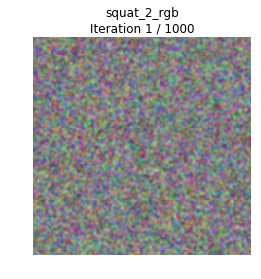

iteration: 1 6.37860012054
iteration: 2 6.58675217628
iteration: 3 6.97003602982
iteration: 4 7.20604610443
iteration: 5 7.47230505943
iteration: 6 7.89559102058
iteration: 7 8.12977719307
iteration: 8 8.37819123268
iteration: 9 8.8010661602
iteration: 10 9.03806710243
iteration: 11 9.32049608231
iteration: 12 9.75257706642
iteration: 13 10.0046551228
iteration: 14 10.236438036
iteration: 15 10.6737651825
iteration: 16 10.9112780094
iteration: 17 11.1901750565
iteration: 18 11.6263730526
iteration: 19 11.8687992096
iteration: 20 12.1546912193
iteration: 21 12.5852820873
iteration: 22 12.8235750198
iteration: 23 13.1066360474
iteration: 24 13.5404760838


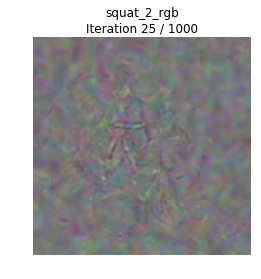

iteration: 25 13.8799180984
iteration: 26 14.1304562092
iteration: 27 14.5434570312
iteration: 28 14.7675921917
iteration: 29 14.9895892143
iteration: 30 15.3873941898
iteration: 31 15.6123361588
iteration: 32 15.8305671215
iteration: 33 16.1387400627
iteration: 34 16.3554382324
iteration: 35 16.5922961235
iteration: 36 16.9310450554
iteration: 37 17.1489210129
iteration: 38 17.3741161823
iteration: 39 17.7262802124
iteration: 40 17.9522092342
iteration: 41 18.1899762154
iteration: 42 18.4993212223
iteration: 43 18.7218260765
iteration: 44 18.9478600025
iteration: 45 19.2834692001
iteration: 46 19.5059390068
iteration: 47 19.7513380051
iteration: 48 20.1500952244
iteration: 49 20.3747911453


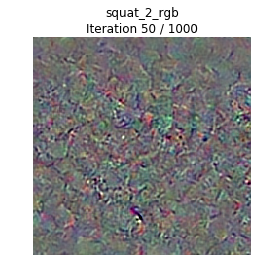

iteration: 50 20.7262990475
iteration: 51 21.0655372143
iteration: 52 21.2861962318
iteration: 53 21.5288100243
iteration: 54 21.8741540909
iteration: 55 22.0926911831
iteration: 56 22.3213272095
iteration: 57 22.6904602051
iteration: 58 22.9145770073
iteration: 59 23.160172224
iteration: 60 23.4614651203
iteration: 61 23.6653161049
iteration: 62 23.8758051395
iteration: 63 24.2455370426
iteration: 64 24.471529007
iteration: 65 24.7095470428
iteration: 66 25.049418211
iteration: 67 25.2710080147
iteration: 68 25.5172851086
iteration: 69 25.9086802006
iteration: 70 26.1493802071
iteration: 71 26.4141921997
iteration: 72 26.7509109974
iteration: 73 26.9726960659
iteration: 74 27.2225041389


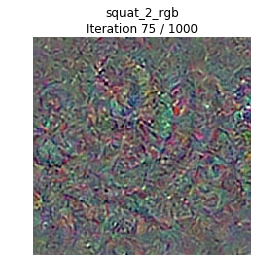

iteration: 75 27.8026070595
iteration: 76 28.0387711525
iteration: 77 28.2867240906
iteration: 78 28.6948571205
iteration: 79 28.9281020164
iteration: 80 29.1724171638
iteration: 81 29.5656080246
iteration: 82 29.8167390823
iteration: 83 30.1025841236
iteration: 84 30.528039217
iteration: 85 30.7593560219
iteration: 86 30.9941542149
iteration: 87 31.3823390007
iteration: 88 31.61977005
iteration: 89 31.8935751915
iteration: 90 32.2845301628
iteration: 91 32.5082161427
iteration: 92 32.7597851753
iteration: 93 33.1053791046
iteration: 94 33.3264360428
iteration: 95 33.5727081299
iteration: 96 33.9783730507
iteration: 97 34.2123670578
iteration: 98 34.4353411198
iteration: 99 34.8177340031


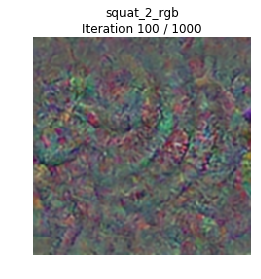

iteration: 100 35.1480031013
iteration: 101 35.3797922134
iteration: 102 35.7631962299
iteration: 103 35.9856581688
iteration: 104 36.2276201248
iteration: 105 36.6191380024
iteration: 106 36.8852310181
iteration: 107 37.1026380062
iteration: 108 37.4788990021
iteration: 109 37.7223191261
iteration: 110 38.0011920929
iteration: 111 38.404364109
iteration: 112 38.6282241344
iteration: 113 38.8536221981
iteration: 114 39.2382011414
iteration: 115 39.4713821411
iteration: 116 39.7211871147
iteration: 117 40.0675661564
iteration: 118 40.2861711979
iteration: 119 40.5083332062
iteration: 120 40.8907542229
iteration: 121 41.1234881878
iteration: 122 41.4063460827
iteration: 123 41.841438055
iteration: 124 42.1095221043


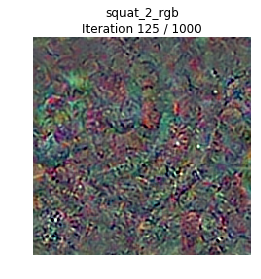

iteration: 125 42.4928851128
iteration: 126 42.8766272068
iteration: 127 43.1028270721
iteration: 128 43.3269190788
iteration: 129 43.6599991322
iteration: 130 43.883133173
iteration: 131 44.1216289997
iteration: 132 44.4677350521
iteration: 133 44.6921892166
iteration: 134 44.9421141148
iteration: 135 45.3679111004
iteration: 136 45.6146571636
iteration: 137 45.8974502087
iteration: 138 46.3257250786
iteration: 139 46.5574231148
iteration: 140 46.7864611149
iteration: 141 47.2059412003
iteration: 142 47.4511051178
iteration: 143 47.7239232063
iteration: 144 48.1003861427
iteration: 145 48.3302211761
iteration: 146 48.5827710629
iteration: 147 48.9403851032
iteration: 148 49.1717970371
iteration: 149 49.4550201893


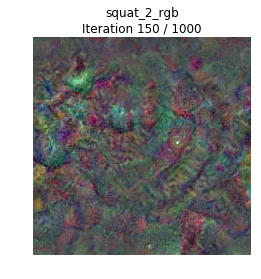

iteration: 150 50.0512042046
iteration: 151 50.2836890221
iteration: 152 50.5319461823
iteration: 153 50.9343490601
iteration: 154 51.1704721451
iteration: 155 51.4488620758
iteration: 156 51.8893911839
iteration: 157 52.1268620491
iteration: 158 52.3796670437
iteration: 159 52.8197572231
iteration: 160 53.0627961159
iteration: 161 53.3446581364
iteration: 162 53.766531229
iteration: 163 54.0112700462
iteration: 164 54.3049440384
iteration: 165 54.7435450554
iteration: 166 54.9871001244
iteration: 167 55.238270998
iteration: 168 55.6400110722
iteration: 169 55.8735380173
iteration: 170 56.1195921898
iteration: 171 56.438049078
iteration: 172 56.6714301109
iteration: 173 56.960488081
iteration: 174 57.4038660526


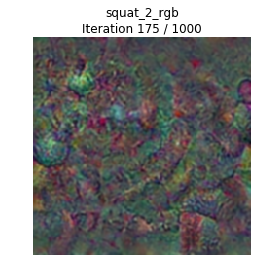

iteration: 175 57.758947134
iteration: 176 58.046831131
iteration: 177 58.4833860397
iteration: 178 58.7310061455
iteration: 179 59.0249261856
iteration: 180 59.4578480721
iteration: 181 59.6921710968
iteration: 182 59.9604020119
iteration: 183 60.4018340111
iteration: 184 60.6361961365
iteration: 185 60.8796770573
iteration: 186 61.2843952179
iteration: 187 61.5181500912
iteration: 188 61.7800152302
iteration: 189 62.2236921787
iteration: 190 62.4793920517
iteration: 191 62.7162132263
iteration: 192 63.1284241676
iteration: 193 63.3668630123
iteration: 194 63.619792223
iteration: 195 64.0456020832
iteration: 196 64.2809231281
iteration: 197 64.5338730812
iteration: 198 64.9430291653
iteration: 199 65.1845312119


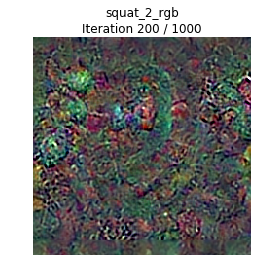

iteration: 200 65.58989501
iteration: 201 65.9676411152
iteration: 202 66.1962661743
iteration: 203 66.614713192
iteration: 204 67.060696125
iteration: 205 67.3008282185
iteration: 206 67.5609190464
iteration: 207 68.0041851997
iteration: 208 68.2420361042
iteration: 209 68.4842011929
iteration: 210 68.9222710133
iteration: 211 69.1664440632
iteration: 212 69.4593532085
iteration: 213 69.9023370743
iteration: 214 70.1434612274
iteration: 215 70.3880591393
iteration: 216 70.7833871841
iteration: 217 71.0162491798
iteration: 218 71.2757380009
iteration: 219 71.6795392036
iteration: 220 71.9131081104
iteration: 221 72.1724991798
iteration: 222 72.5973050594
iteration: 223 72.842097044
iteration: 224 73.1032400131


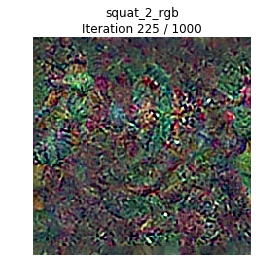

iteration: 225 73.6624751091
iteration: 226 73.9057371616
iteration: 227 74.1942961216
iteration: 228 74.638228178
iteration: 229 74.8870170116
iteration: 230 75.180768013
iteration: 231 75.5988690853
iteration: 232 75.835337162
iteration: 233 76.0984070301
iteration: 234 76.5123031139
iteration: 235 76.7613861561
iteration: 236 77.0320532322
iteration: 237 77.475372076
iteration: 238 77.7227811813
iteration: 239 77.9849472046
iteration: 240 78.4104471207
iteration: 241 78.6475231647
iteration: 242 78.9082531929
iteration: 243 79.3282592297
iteration: 244 79.5674130917
iteration: 245 79.8236830235
iteration: 246 80.2534720898
iteration: 247 80.5008270741
iteration: 248 80.776348114
iteration: 249 81.2388520241


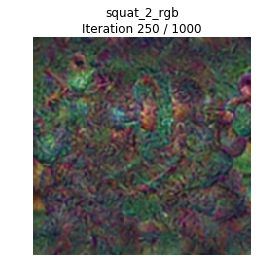

iteration: 250 81.6606450081
iteration: 251 81.95571208
iteration: 252 82.3898191452
iteration: 253 82.6360931396
iteration: 254 82.9364171028
iteration: 255 83.3712980747
iteration: 256 83.6171250343
iteration: 257 83.8970711231
iteration: 258 84.3235330582
iteration: 259 84.5742170811
iteration: 260 84.8649260998
iteration: 261 85.3070211411
iteration: 262 85.5613591671
iteration: 263 85.8341181278
iteration: 264 86.2828280926
iteration: 265 86.5231261253
iteration: 266 86.7929060459
iteration: 267 87.2393841743
iteration: 268 87.4835720062
iteration: 269 87.7282400131
iteration: 270 88.1938741207
iteration: 271 88.4221041203
iteration: 272 88.6571311951
iteration: 273 89.0122151375
iteration: 274 89.2470231056


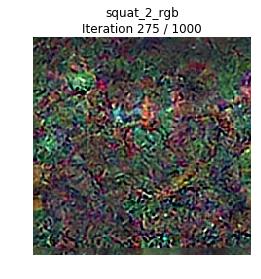

iteration: 275 89.6738700867
iteration: 276 90.0587220192
iteration: 277 90.2989912033
iteration: 278 90.5936450958
iteration: 279 91.0316510201
iteration: 280 91.2676210403
iteration: 281 91.5074632168
iteration: 282 91.9448580742
iteration: 283 92.1826701164
iteration: 284 92.4293031693
iteration: 285 92.7858991623
iteration: 286 93.015045166
iteration: 287 93.2542870045
iteration: 288 93.6318650246
iteration: 289 93.865265131
iteration: 290 94.1306650639
iteration: 291 94.5166330338
iteration: 292 94.7507810593
iteration: 293 95.0100221634
iteration: 294 95.4031832218
iteration: 295 95.6414561272
iteration: 296 95.8786451817
iteration: 297 96.2284731865
iteration: 298 96.4634931087
iteration: 299 96.7339720726


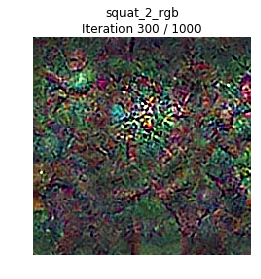

iteration: 300 97.2432370186
iteration: 301 97.4886522293
iteration: 302 97.783919096
iteration: 303 98.2218940258
iteration: 304 98.4632530212
iteration: 305 98.7253360748
iteration: 306 99.1662960052
iteration: 307 99.4050152302
iteration: 308 99.6658830643
iteration: 309 100.088012218
iteration: 310 100.331393003
iteration: 311 100.591444016
iteration: 312 101.021544218
iteration: 313 101.270248175
iteration: 314 101.54275322
iteration: 315 101.943261147
iteration: 316 102.174737215
iteration: 317 102.408964157
iteration: 318 102.811606169
iteration: 319 103.057169199
iteration: 320 103.321911097
iteration: 321 103.748736143
iteration: 322 103.998209
iteration: 323 104.293861151
iteration: 324 104.654718161


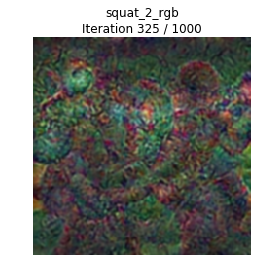

iteration: 325 104.992577076
iteration: 326 105.2308321
iteration: 327 105.639127016
iteration: 328 105.889517069
iteration: 329 106.146187067
iteration: 330 106.543048143
iteration: 331 106.783288002
iteration: 332 107.052685022
iteration: 333 107.450722218
iteration: 334 107.691353083
iteration: 335 107.965695143
iteration: 336 108.392687082
iteration: 337 108.643731117
iteration: 338 108.94039607
iteration: 339 109.393172026
iteration: 340 109.639490128
iteration: 341 109.900579214
iteration: 342 110.283651114
iteration: 343 110.530698061
iteration: 344 110.833916187
iteration: 345 111.278843164
iteration: 346 111.530389071
iteration: 347 111.781336069
iteration: 348 112.182776213
iteration: 349 112.434140205


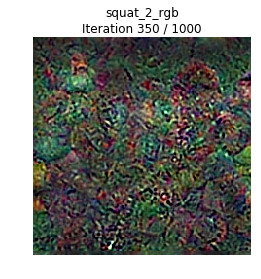

iteration: 350 112.863524199
iteration: 351 113.254763126
iteration: 352 113.491542101
iteration: 353 113.743302107
iteration: 354 114.100900173
iteration: 355 114.337622166
iteration: 356 114.616093159
iteration: 357 115.050034046
iteration: 358 115.295102119
iteration: 359 115.566732168
iteration: 360 115.978658199
iteration: 361 116.221316099
iteration: 362 116.492114067
iteration: 363 116.89279604
iteration: 364 117.139966011
iteration: 365 117.406689167
iteration: 366 117.78154707
iteration: 367 118.020955086
iteration: 368 118.290801048
iteration: 369 118.694848061
iteration: 370 118.929629087
iteration: 371 119.167408228
iteration: 372 119.546058178
iteration: 373 119.801888227
iteration: 374 120.107060194


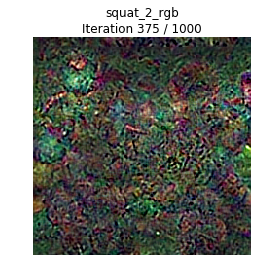

iteration: 375 120.629437208
iteration: 376 120.877762079
iteration: 377 121.194559097
iteration: 378 121.613132
iteration: 379 121.851740122
iteration: 380 122.122804165
iteration: 381 122.580860138
iteration: 382 122.830879211
iteration: 383 123.10759306
iteration: 384 123.53938508
iteration: 385 123.791822195
iteration: 386 124.093784094
iteration: 387 124.533603191
iteration: 388 124.779542208
iteration: 389 125.044671059
iteration: 390 125.44060111
iteration: 391 125.681161165
iteration: 392 125.953845024
iteration: 393 126.384273052
iteration: 394 126.630993128
iteration: 395 126.894460201
iteration: 396 127.316655159
iteration: 397 127.56034708
iteration: 398 127.836190224
iteration: 399 128.278350115


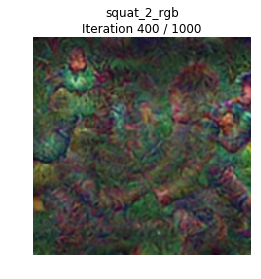

iteration: 400 128.702603102
iteration: 401 128.938244104
iteration: 402 129.303473234
iteration: 403 129.54519105
iteration: 404 129.817254066
iteration: 405 130.248060226
iteration: 406 130.496310234
iteration: 407 130.745087147
iteration: 408 131.104364157
iteration: 409 131.345165014
iteration: 410 131.609886169
iteration: 411 132.045849085
iteration: 412 132.297162056
iteration: 413 132.600454092
iteration: 414 133.006644011
iteration: 415 133.246582031
iteration: 416 133.524875164
iteration: 417 133.969715118
iteration: 418 134.213886023
iteration: 419 134.479395151
iteration: 420 134.844153166
iteration: 421 135.086582184
iteration: 422 135.350757122
iteration: 423 135.774283171
iteration: 424 136.029887199


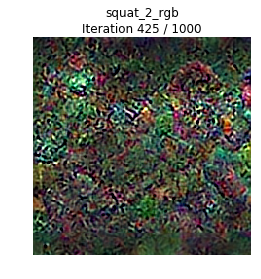

iteration: 425 136.39817214
iteration: 426 136.850435019
iteration: 427 137.11135602
iteration: 428 137.383816004
iteration: 429 137.793433189
iteration: 430 138.044348001
iteration: 431 138.311465025
iteration: 432 138.749483109
iteration: 433 139.006080151
iteration: 434 139.288458109
iteration: 435 139.723830223
iteration: 436 139.974391222
iteration: 437 140.266037226
iteration: 438 140.718747139
iteration: 439 140.977101088
iteration: 440 141.245111227
iteration: 441 141.655643225
iteration: 442 141.909370184
iteration: 443 142.213783026
iteration: 444 142.655978203
iteration: 445 142.904833078
iteration: 446 143.172111034
iteration: 447 143.530697107
iteration: 448 143.78057003
iteration: 449 144.056739092


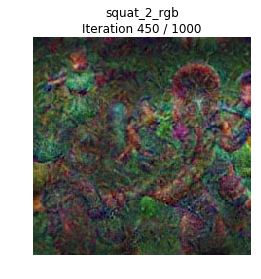

iteration: 450 144.620283127
iteration: 451 144.877467155
iteration: 452 145.157524109
iteration: 453 145.609505177
iteration: 454 145.874319077
iteration: 455 146.15855813
iteration: 456 146.603785038
iteration: 457 146.851129055
iteration: 458 147.120920181
iteration: 459 147.529672146
iteration: 460 147.774364233
iteration: 461 148.035982132
iteration: 462 148.418381214
iteration: 463 148.670115232
iteration: 464 148.929866076
iteration: 465 149.360232115
iteration: 466 149.612972021
iteration: 467 149.875117064
iteration: 468 150.305965185
iteration: 469 150.562585115
iteration: 470 150.842224121
iteration: 471 151.30965209
iteration: 472 151.570502043
iteration: 473 151.880937099
iteration: 474 152.339207172


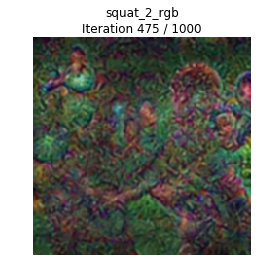

iteration: 475 152.74223423
iteration: 476 153.012422085
iteration: 477 153.428009033
iteration: 478 153.688494205
iteration: 479 153.999228001
iteration: 480 154.422823191
iteration: 481 154.669968128
iteration: 482 154.944028139
iteration: 483 155.318782091
iteration: 484 155.562018156
iteration: 485 155.832885027
iteration: 486 156.224214077
iteration: 487 156.467950106
iteration: 488 156.735727072
iteration: 489 157.21156621
iteration: 490 157.457565069
iteration: 491 157.743059158
iteration: 492 158.198228121
iteration: 493 158.449087143
iteration: 494 158.727210045
iteration: 495 159.17862916
iteration: 496 159.432694197
iteration: 497 159.705766201
iteration: 498 160.114597082
iteration: 499 160.369422197


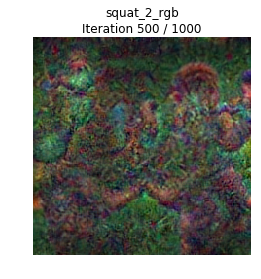

iteration: 500 160.828333139
iteration: 501 161.264344215
iteration: 502 161.514237165
iteration: 503 161.79106307
iteration: 504 162.207982063
iteration: 505 162.456958055
iteration: 506 162.737891197
iteration: 507 163.193172216
iteration: 508 163.444324017
iteration: 509 163.734662056
iteration: 510 164.165743113
iteration: 511 164.404520035
iteration: 512 164.648300171
iteration: 513 165.07931304
iteration: 514 165.340460062
iteration: 515 165.646238089
iteration: 516 166.085988045
iteration: 517 166.330020189
iteration: 518 166.559992075
iteration: 519 166.980779171
iteration: 520 167.23280406
iteration: 521 167.505367041
iteration: 522 167.919500113
iteration: 523 168.16920805
iteration: 524 168.435360193


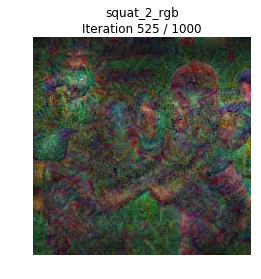

iteration: 525 168.931734085
iteration: 526 169.17861104
iteration: 527 169.440682173
iteration: 528 169.842429161
iteration: 529 170.091424227
iteration: 530 170.370531082
iteration: 531 170.833801031
iteration: 532 171.102904081
iteration: 533 171.4098351
iteration: 534 171.850961208
iteration: 535 172.109283209
iteration: 536 172.37374115
iteration: 537 172.736069202
iteration: 538 172.977027178
iteration: 539 173.233520031
iteration: 540 173.685006142
iteration: 541 173.938474178
iteration: 542 174.226038218
iteration: 543 174.66330409
iteration: 544 174.905798197
iteration: 545 175.15638113
iteration: 546 175.552429199
iteration: 547 175.80092907
iteration: 548 176.067625046
iteration: 549 176.467414141


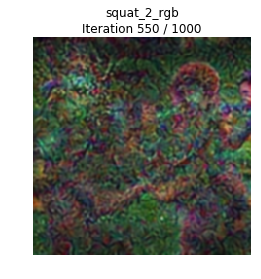

iteration: 550 176.826437235
iteration: 551 177.138787031
iteration: 552 177.566436052
iteration: 553 177.815080166
iteration: 554 178.093720198
iteration: 555 178.549058199
iteration: 556 178.801085234
iteration: 557 179.083407164
iteration: 558 179.535265207
iteration: 559 179.794014215
iteration: 560 180.0639112
iteration: 561 180.431458235
iteration: 562 180.675800085
iteration: 563 180.933890104
iteration: 564 181.402173042
iteration: 565 181.659533024
iteration: 566 181.944932222
iteration: 567 182.396785021
iteration: 568 182.658102036
iteration: 569 182.968861103
iteration: 570 183.403845072
iteration: 571 183.664003134
iteration: 572 183.938152075
iteration: 573 184.374588013
iteration: 574 184.638167143


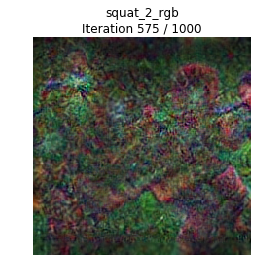

iteration: 575 185.107349157
iteration: 576 185.550562143
iteration: 577 185.799766064
iteration: 578 186.076459169
iteration: 579 186.523452997
iteration: 580 186.786167145
iteration: 581 187.085815191
iteration: 582 187.493169069
iteration: 583 187.753036022
iteration: 584 188.045798063
iteration: 585 188.43970108
iteration: 586 188.703479052
iteration: 587 189.019176006
iteration: 588 189.453668118
iteration: 589 189.709491014
iteration: 590 189.989884138
iteration: 591 190.423325062
iteration: 592 190.692521095
iteration: 593 191.000424147
iteration: 594 191.441421032
iteration: 595 191.710613012
iteration: 596 192.029534101
iteration: 597 192.486037016
iteration: 598 192.743642092
iteration: 599 193.021179199


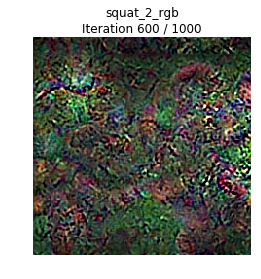

iteration: 600 193.519142151
iteration: 601 193.77185607
iteration: 602 194.054253101
iteration: 603 194.460585117
iteration: 604 194.721991062
iteration: 605 195.042213202
iteration: 606 195.477335215
iteration: 607 195.725947142
iteration: 608 196.0000422
iteration: 609 196.410973072
iteration: 610 196.667217016
iteration: 611 196.957074165
iteration: 612 197.406819105
iteration: 613 197.676997185
iteration: 614 197.995526075
iteration: 615 198.425695181
iteration: 616 198.678365231
iteration: 617 198.937596083
iteration: 618 199.311864138
iteration: 619 199.559042215
iteration: 620 199.819140196
iteration: 621 200.191996098
iteration: 622 200.429335117
iteration: 623 200.680884123
iteration: 624 201.052003145


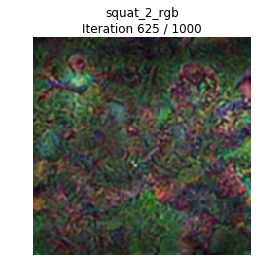

iteration: 625 201.401301146
iteration: 626 201.691457033
iteration: 627 202.157313108
iteration: 628 202.413911104
iteration: 629 202.676291227
iteration: 630 203.118619204
iteration: 631 203.379688025
iteration: 632 203.674090147
iteration: 633 204.140469074
iteration: 634 204.399714231
iteration: 635 204.690344095
iteration: 636 205.108065128
iteration: 637 205.367294073
iteration: 638 205.679228067
iteration: 639 206.123189211
iteration: 640 206.381437063
iteration: 641 206.659370184
iteration: 642 207.121551037
iteration: 643 207.37789917
iteration: 644 207.642635107
iteration: 645 208.118111134
iteration: 646 208.381190062
iteration: 647 208.673103094
iteration: 648 209.083507061
iteration: 649 209.365130186


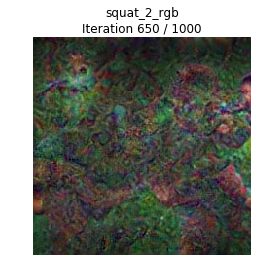

iteration: 650 209.778032064
iteration: 651 210.226985216
iteration: 652 210.494714022
iteration: 653 210.809555054
iteration: 654 211.265835047
iteration: 655 211.524124146
iteration: 656 211.803294182
iteration: 657 212.213528156
iteration: 658 212.464520216
iteration: 659 212.716647148
iteration: 660 213.152034998
iteration: 661 213.41258502
iteration: 662 213.700597048
iteration: 663 214.162111044
iteration: 664 214.417193174
iteration: 665 214.698784113
iteration: 666 215.127632141
iteration: 667 215.395103216
iteration: 668 215.709905148
iteration: 669 216.145475149
iteration: 670 216.401280165
iteration: 671 216.674927235
iteration: 672 217.079552174
iteration: 673 217.329441071
iteration: 674 217.587835073


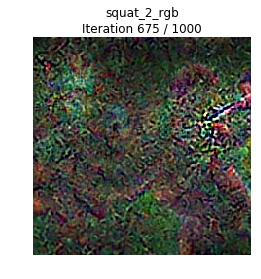

iteration: 675 218.038032055
iteration: 676 218.284610033
iteration: 677 218.531918049
iteration: 678 218.875344038
iteration: 679 219.120071173
iteration: 680 219.397880077
iteration: 681 219.849946022
iteration: 682 220.109209061
iteration: 683 220.394068003
iteration: 684 220.850952148
iteration: 685 221.118723154
iteration: 686 221.429146051
iteration: 687 221.884632111
iteration: 688 222.152817011
iteration: 689 222.43375802
iteration: 690 222.872527122
iteration: 691 223.146327019
iteration: 692 223.465947151
iteration: 693 223.897577047
iteration: 694 224.153059006
iteration: 695 224.430364132
iteration: 696 224.889489174
iteration: 697 225.167500019
iteration: 698 225.490658045
iteration: 699 225.950069189


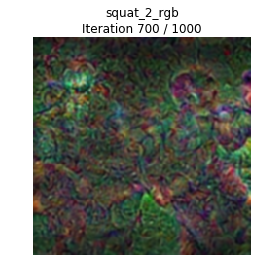

iteration: 700 226.316835165
iteration: 701 226.603251219
iteration: 702 227.013881207
iteration: 703 227.282133102
iteration: 704 227.598883152
iteration: 705 228.059911013
iteration: 706 228.325528145
iteration: 707 228.588197231
iteration: 708 229.031355143
iteration: 709 229.297315121
iteration: 710 229.580384016
iteration: 711 229.984813213
iteration: 712 230.24476409
iteration: 713 230.53454423
iteration: 714 231.005120039
iteration: 715 231.279999018
iteration: 716 231.601461172
iteration: 717 232.026899099
iteration: 718 232.284236193
iteration: 719 232.562116146
iteration: 720 233.006824017
iteration: 721 233.284677029
iteration: 722 233.592116117
iteration: 723 234.023038149
iteration: 724 234.298770189


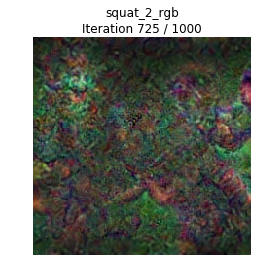

iteration: 725 234.726066113
iteration: 726 235.183288097
iteration: 727 235.451673031
iteration: 728 235.752848148
iteration: 729 236.222055197
iteration: 730 236.484997034
iteration: 731 236.779315233
iteration: 732 237.270886183
iteration: 733 237.549146175
iteration: 734 237.872783184
iteration: 735 238.339664221
iteration: 736 238.607589006
iteration: 737 238.901046038
iteration: 738 239.383073092
iteration: 739 239.659174204
iteration: 740 239.945286036
iteration: 741 240.391008139
iteration: 742 240.658845186
iteration: 743 240.960922003
iteration: 744 241.419673204
iteration: 745 241.695087194
iteration: 746 242.017291069
iteration: 747 242.437423229
iteration: 748 242.689896107
iteration: 749 242.94848609


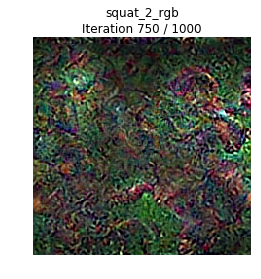

iteration: 750 243.4167521
iteration: 751 243.67351222
iteration: 752 243.953803062
iteration: 753 244.572067022
iteration: 754 244.835082054
iteration: 755 245.130695105
iteration: 756 245.595157146
iteration: 757 245.864274025
iteration: 758 246.15229702
iteration: 759 246.535277128
iteration: 760 246.792023182
iteration: 761 247.057503223
iteration: 762 247.466088057
iteration: 763 247.731180191
iteration: 764 248.022144079
iteration: 765 248.433515072
iteration: 766 248.6997962
iteration: 767 248.99498105
iteration: 768 249.407816172
iteration: 769 249.673940182
iteration: 770 249.965164185
iteration: 771 250.379170179
iteration: 772 250.64457202
iteration: 773 250.93721509
iteration: 774 251.352827072


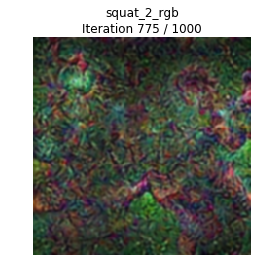

iteration: 775 251.722100019
iteration: 776 252.012895107
iteration: 777 252.430656195
iteration: 778 252.706216097
iteration: 779 253.040035009
iteration: 780 253.461455107
iteration: 781 253.727321148
iteration: 782 254.015818119
iteration: 783 254.395560026
iteration: 784 254.656498194
iteration: 785 254.92782402
iteration: 786 255.342056036
iteration: 787 255.621214151
iteration: 788 255.953113079
iteration: 789 256.420294046
iteration: 790 256.701801062
iteration: 791 257.025159121
iteration: 792 257.452860117
iteration: 793 257.718049049
iteration: 794 257.984904051
iteration: 795 258.473369122
iteration: 796 258.743295193
iteration: 797 259.029173136
iteration: 798 259.481586218
iteration: 799 259.76329422


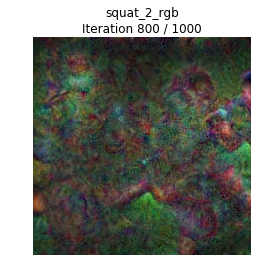

iteration: 800 260.20849514
iteration: 801 260.696687222
iteration: 802 260.969713211
iteration: 803 261.274960041
iteration: 804 261.766399145
iteration: 805 262.048976183
iteration: 806 262.343816042
iteration: 807 262.754501104
iteration: 808 263.026695013
iteration: 809 263.351366043
iteration: 810 263.817414999
iteration: 811 264.095141172
iteration: 812 264.433339119
iteration: 813 264.899223089
iteration: 814 265.176756144
iteration: 815 265.503350019
iteration: 816 265.970404148
iteration: 817 266.258183002
iteration: 818 266.591775179
iteration: 819 267.056704044
iteration: 820 267.343119144
iteration: 821 267.654819012
iteration: 822 268.051198006
iteration: 823 268.320536137
iteration: 824 268.613332033


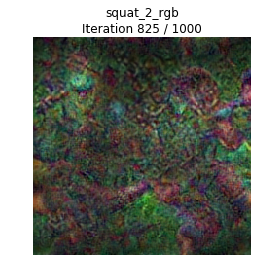

iteration: 825 269.131493092
iteration: 826 269.407243013
iteration: 827 269.744929075
iteration: 828 270.193614006
iteration: 829 270.459387064
iteration: 830 270.761799097
iteration: 831 271.252844095
iteration: 832 271.527651072
iteration: 833 271.801463127
iteration: 834 272.1790452
iteration: 835 272.429147005
iteration: 836 272.719822168
iteration: 837 273.188474178
iteration: 838 273.465707064
iteration: 839 273.77236104
iteration: 840 274.240373135
iteration: 841 274.540883064
iteration: 842 274.833947182
iteration: 843 275.320798159
iteration: 844 275.596085072
iteration: 845 275.888423204
iteration: 846 276.382780075
iteration: 847 276.66012311
iteration: 848 276.962284088
iteration: 849 277.421048164


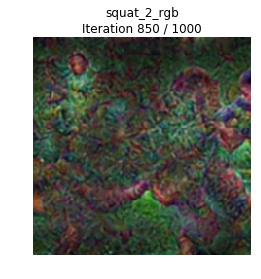

iteration: 850 277.805507183
iteration: 851 278.101425171
iteration: 852 278.516253233
iteration: 853 278.788088083
iteration: 854 279.09051609
iteration: 855 279.55946517
iteration: 856 279.855345011
iteration: 857 280.190492153
iteration: 858 280.659384012
iteration: 859 280.936137199
iteration: 860 281.229050159
iteration: 861 281.640098095
iteration: 862 281.918538094
iteration: 863 282.243026018
iteration: 864 282.621302128
iteration: 865 282.888517141
iteration: 866 283.192533016
iteration: 867 283.69106102
iteration: 868 283.975699186
iteration: 869 284.265486002
iteration: 870 284.657503128
iteration: 871 284.926692009
iteration: 872 285.220057011
iteration: 873 285.634289026
iteration: 874 285.907770157


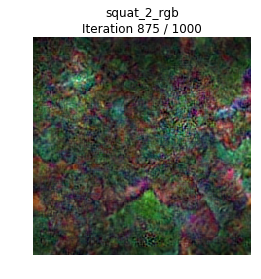

iteration: 875 286.300117016
iteration: 876 286.719343185
iteration: 877 286.990112066
iteration: 878 287.278486013
iteration: 879 287.6650002
iteration: 880 287.933047056
iteration: 881 288.228206158
iteration: 882 288.621866226
iteration: 883 288.891298056
iteration: 884 289.185601234
iteration: 885 289.574464083
iteration: 886 289.841324091
iteration: 887 290.129408121
iteration: 888 290.50850606
iteration: 889 290.777509212
iteration: 890 291.039782047
iteration: 891 291.401444197
iteration: 892 291.666648149
iteration: 893 291.946554184
iteration: 894 292.4365201
iteration: 895 292.732191086
iteration: 896 293.068397045
iteration: 897 293.537786007
iteration: 898 293.808958054
iteration: 899 294.110152006


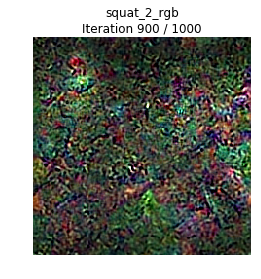

iteration: 900 294.744332075
iteration: 901 295.014917135
iteration: 902 295.29415822
iteration: 903 295.771221161
iteration: 904 296.062174082
iteration: 905 296.392355204
iteration: 906 296.834353209
iteration: 907 297.119274139
iteration: 908 297.443425179
iteration: 909 297.842474222
iteration: 910 298.125663042
iteration: 911 298.457436085
iteration: 912 298.901766062
iteration: 913 299.179630041
iteration: 914 299.472362041
iteration: 915 299.889462233
iteration: 916 300.165122032
iteration: 917 300.468395233
iteration: 918 300.91924715
iteration: 919 301.203109026
iteration: 920 301.477183104
iteration: 921 301.897033215
iteration: 922 302.168315172
iteration: 923 302.47639823
iteration: 924 302.961982012


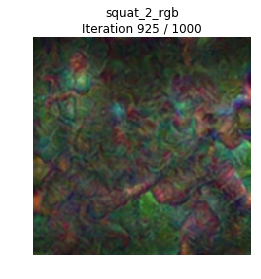

iteration: 925 303.357334137
iteration: 926 303.649829149
iteration: 927 304.069863081
iteration: 928 304.346414089
iteration: 929 304.666628122
iteration: 930 305.147729158
iteration: 931 305.423256159
iteration: 932 305.704345226
iteration: 933 306.159062147
iteration: 934 306.43960619
iteration: 935 306.779747009
iteration: 936 307.277322054
iteration: 937 307.558335066
iteration: 938 307.874373198
iteration: 939 308.343696117
iteration: 940 308.617431164
iteration: 941 308.92387104
iteration: 942 309.357117176
iteration: 943 309.629464149
iteration: 944 309.939273119
iteration: 945 310.357288122
iteration: 946 310.641272068
iteration: 947 310.99114418
iteration: 948 311.387271166
iteration: 949 311.667516232


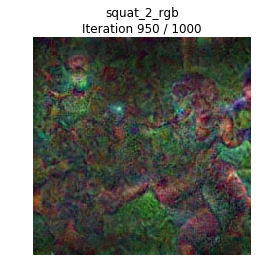

iteration: 950 312.109714031
iteration: 951 312.506544113
iteration: 952 312.775042057
iteration: 953 313.033756018
iteration: 954 313.422208071
iteration: 955 313.708500147
iteration: 956 314.01307106
iteration: 957 314.432786226
iteration: 958 314.710769176
iteration: 959 315.078496218
iteration: 960 315.560109138
iteration: 961 315.862449169
iteration: 962 316.184327126
iteration: 963 316.643748045
iteration: 964 316.939727068
iteration: 965 317.282212019
iteration: 966 317.791175127
iteration: 967 318.080093145
iteration: 968 318.380568027
iteration: 969 318.781845093
iteration: 970 319.052607059
iteration: 971 319.339573145
iteration: 972 319.80670023
iteration: 973 320.094238043
iteration: 974 320.405174017


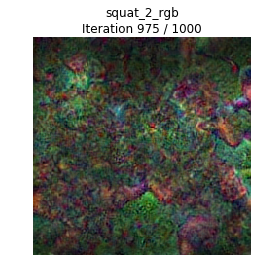

iteration: 975 320.973726034
iteration: 976 321.249389172
iteration: 977 321.548970222
iteration: 978 321.966361046
iteration: 979 322.240271091
iteration: 980 322.543300152
iteration: 981 322.956839085
iteration: 982 323.232873201
iteration: 983 323.532229185
iteration: 984 323.971497059
iteration: 985 324.263315201
iteration: 986 324.608741999
iteration: 987 325.06995821
iteration: 988 325.357882023
iteration: 989 325.692358017
iteration: 990 326.095093012
iteration: 991 326.37630415
iteration: 992 326.692685127
iteration: 993 327.118643045
iteration: 994 327.392985106
iteration: 995 327.682874203
iteration: 996 328.158743143
iteration: 997 328.438202143
iteration: 998 328.741076231
iteration: 999 329.176178217
file_name experiments_rgb/squat_2/squat_2_rgb{}.png


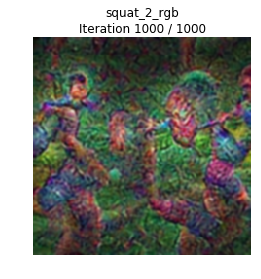

In [6]:
"""
Run RGB visualization only
Make sure graph is built in previous cell before running this cell
"""
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # this line may vary depending on hardware
print(model_logits)
print(rgb_input)
# 279: 'rock scissors paper' 345: 'sword fighting' 277: 'robot dancing' 
# 185: 'making a sandwich', 110: 'eating cake', 320: 'sniffing'
to_visualize = [279, 345, 277, 185, 110, 320]
target = 330 # change this to the desired class 
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        # number of frames must be >= 9 or else kernel crashes
        rgb_visual_gif = create_class_visualization(sess, rgb_input, flow_input, target, rgb_logits, action_name+"_2", 
                                   stream_type='rgb', scale_every=1000)

The cell below is used to generate all Optical Flow Visualizations. The hyperparameters inputted below were the ones we found to be best, but we were unable to ever create any good Optical Flow results that were interpretable. 

In [ ]:
"""
Run FLOW visualization only.
Make sure graph is built in previous cell before running this cell
"""
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # this line may vary depending on hardware
print(model_logits)
print(flow_input)
target = 171
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
        flow_visual_gif = create_class_visualization(sess, rgb_input, flow_input, target, flow_logits, 
                                                     action_name + "test", stream_type='flow', num_frames=25, 
                                                     num_iterations=1000, l2_reg=1e-2, learning_rate=1.5, 
                                                     blur_every=10, max_jitter=32, sigma=.5)

In [7]:
"""
Print all classes
"""
indexes = range(len(kinetics_classes))
class_to_index = dict(zip(kinetics_classes, indexes))
index_to_class = dict(zip(indexes, kinetics_classes))
print(index_to_class)


{0: 'abseiling', 1: 'air drumming', 2: 'answering questions', 3: 'applauding', 4: 'applying cream', 5: 'archery', 6: 'arm wrestling', 7: 'arranging flowers', 8: 'assembling computer', 9: 'auctioning', 10: 'baby waking up', 11: 'baking cookies', 12: 'balloon blowing', 13: 'bandaging', 14: 'barbequing', 15: 'bartending', 16: 'beatboxing', 17: 'bee keeping', 18: 'belly dancing', 19: 'bench pressing', 20: 'bending back', 21: 'bending metal', 22: 'biking through snow', 23: 'blasting sand', 24: 'blowing glass', 25: 'blowing leaves', 26: 'blowing nose', 27: 'blowing out candles', 28: 'bobsledding', 29: 'bookbinding', 30: 'bouncing on trampoline', 31: 'bowling', 32: 'braiding hair', 33: 'breading or breadcrumbing', 34: 'breakdancing', 35: 'brush painting', 36: 'brushing hair', 37: 'brushing teeth', 38: 'building cabinet', 39: 'building shed', 40: 'bungee jumping', 41: 'busking', 42: 'canoeing or kayaking', 43: 'capoeira', 44: 'carrying baby', 45: 'cartwheeling', 46: 'carving pumpkin', 47: 'cat